In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd

In [2]:
import pickle
import tensorflow as tf
import numpy as np
import tf_util
import gym
import load_policy
import numpy as np

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"

# Functions

In [3]:
def rollout(expert_policy_file,envname,max_timesteps,num_rollouts,render):
    
    policy_fn,a_ba = load_policy.load_policy(expert_policy_file)
    
    with tf.Session():
        # initializes tensor flow variables 
        tf_util.initialize() 

        # make gym environment
        env = gym.make(envname)
        max_steps = max_timesteps or env.spec.timestep_limit

        returns = []
        observations = []
        actions = []
        for i in range(num_rollouts):
            #print('iter', i)
            obs = env.reset()
            done = False
            totalr = 0.
            steps = 0
            while not done:
                action = policy_fn(obs[None,:])
                observations.append(obs)
                actions.append(action)
                obs, r, done, _ = env.step(action)
                totalr += r
                steps += 1
                if render:
                    env.render()
                #if steps % 100 == 0: print("%i/%i"%(steps, max_steps))
                if steps >= max_steps:
                    break
            returns.append(totalr)

        #print('returns', returns)
        print('mean return', np.mean(returns))
        print('std of return', np.std(returns))

        expert_data = {'observations': np.array(observations),
                       'actions': np.array(actions)}
        env.render(close=True)

    name = expert_policy_file.split('/')[1].split('-')[0]
    np.save('expert_observations_'+name+'_'+str(num_rollouts)+'ro.npy',observations)
    np.save('expert_actions_'+name+'_'+str(num_rollouts)+'ro.npy',actions)
    np.save('expert_returns_'+name+'_'+str(num_rollouts)+'ro.npy',returns)

In [4]:
def load_expert_data(name,normalize=False):
    observations = np.load('expert_observations_'+name+'ro.npy')
    actions = np.load('expert_actions_'+name+'ro.npy')
    actions = actions[:,0,:]
    n_trials = np.shape(observations)[0]
    returns = np.load('expert_returns_'+name+'ro.npy')
    
    # normalize
    if normalize:
        means = np.nanmean(observations,axis=0)
        stds = np.nanstd(observations,axis=0)
        observations = (observations-means)/stds
    else:
        means=None
        stds=None
    if np.any(np.isnan(observations)):
        observations[np.isnan(observations)]=0.0 
        print('one of inputs is all 0s')
    
    
    print('Training Data:')
    print('observations {0}'.format(np.shape(observations)))
    print('actions {0}'.format(np.shape(actions)))
    return(observations,actions,n_trials,returns,means,stds)

In [5]:
def build_network(observations,actions,hlayers=2,n_hidden_1=64,n_hidden_2=64,learning_rate=0.01):
    
    # set up network 
    d_obs = np.shape(observations)[1]
    d_acts = np.shape(actions)[1]  # change this.. it's not classes.. 


    # input layer input 
    Obs = tf.placeholder("float", [None, d_obs]) # input place holder 
    Acts = tf.placeholder("float",[None, d_acts]) #target place holder 

    W0 = tf.Variable(tf.random_normal([d_obs, n_hidden_1]))
    b0 = tf.Variable(tf.random_normal([1, n_hidden_1]))
    

    if hlayers==1:
        A1 = tf.tanh(tf.matmul(Obs, W0) + b0)
        W1 = tf.Variable(tf.random_normal([n_hidden_1,d_acts ]))
        b1 = tf.Variable(tf.random_normal([1,d_acts]))
    
        Acts_ = tf.matmul(A1, W1) + b1  # predictions 
        
    elif hlayers==2:
        
        A1 = tf.tanh(tf.matmul(Obs, W0) + b0)
        W1 = tf.Variable(tf.random_normal([n_hidden_1,n_hidden_2 ]))
        b1 = tf.Variable(tf.random_normal([1,n_hidden_2]))
        
        A2 = tf.tanh(tf.matmul(A1, W1) + b1)
        W2 = tf.Variable(tf.random_normal([n_hidden_2, d_acts]))
        b2 = tf.Variable(tf.random_normal([1, d_acts]))
        
        Acts_ = tf.matmul(A2, W2) + b2  # predictions 
        

    # define loss
    mse_loss = tf.reduce_mean(tf.pow(Acts-Acts_, 2)) #mean so the loss is not dependent on the number of training examples

    # training step
    #train_step = tf.train.AdagradOptimizer(learning_rate).minimize(mse_loss)
    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(mse_loss)
    
    # Initializing the variables
    init = tf.global_variables_initializer() # returns an op that then will initialize all variables in network
    return(init,Obs,train_step,Acts,Acts_,mse_loss)

In [6]:
def train_and_evaluate_network_w_dagger(expert_data_file,envname,max_steps = None,
                                        normalize_obs=False, n_steps=100,
                                        hlayers=1,n_hidden_1=64,n_hidden_2=64,learning_rate=0.01,
                                        dagger=True,expert_step=False,whichrender=[],steps_to_run_before_gym=10):
    
    # load data 
    (observations,actions,n_trials,returns_expert,means,stds) = load_expert_data(expert_data_file,
                                                                                 normalize=normalize_obs)
    
    print('returns expert {0}'.format(np.mean(returns_expert)))
    # build a network
    (init,Obs,train_step,Acts,Acts_,mse_loss) = build_network(observations,
                                                              actions,hlayers=hlayers,
                                                              n_hidden_1=n_hidden_1,n_hidden_2=n_hidden_2,
                                                              learning_rate=learning_rate)

    # load the expert
    policy_fn,a_ba = load_policy.load_policy('experts/'+envname+'.pkl')

    # train
    with tf.Session() as sess:
        
        # initialize tf variables 
        sess.run(init) 

        # storage 
        losses = []
        returns = []

        # make gym environment
        env = gym.make(envname)
        if max_steps is None:
            max_steps = env.spec.timestep_limit

        # step
        for step in range(n_steps):

            # print out summary every 100 steps
            if step%100==0:
                print('gradient step: {0}'.format(step))
                print('average returns (prev 100 steps): {0}'.format(np.nanmean(returns[-100::])))
                print('observations shape: {0}'.format(np.shape(observations)))
                print('actions shape: {0}'.format(np.shape(actions)))

            # render for certain steps
            if step in whichrender:
                render=True
            else:
                render=False
                    
            # take a gradient step 
            sess.run(train_step, feed_dict={Obs: observations, Acts: actions})
            
            # store loss 
            batch_loss = sess.run(mse_loss, feed_dict={Obs: observations, Acts: actions})
            losses.append(batch_loss)

            # run through one episode in the gym (every n gradient steps)
            if step%steps_to_run_before_gym==0:
                observations_episode = []
                actions_episode = []
                actions_episode_expert_labels = []

                obs = env.reset()
                done = False
                totalr = 0.
                steps = 0
            
                while not done:

                    if dagger:
                        # label actions using the expert 
                        action_exp = policy_fn(obs[None,:])
                        actions_episode_expert_labels.append(action_exp)

                    # normalize observations (don't normalize for the expert)
                    if normalize_obs:
                        obs = (obs-means)/stds
                        obs[np.isnan(obs)]=0.0

                    observations_episode.append(obs)

                    # decide action with my network 
                    action = sess.run(Acts_,feed_dict={Obs: obs[None,:]})
                    actions_episode.append(action)

                    # take a step
                    if expert_step:
                        obs, r, done, _ = env.step(action_exp)
                    else:
                        obs, r, done, _ = env.step(action)

                    totalr += r
                    steps += 1
                    if render:
                        env.render()
                        env.render(close=True)
                    if steps >= max_steps:
                        break
                returns.append(totalr)

                if dagger: 
                    # add the new observations..
                    observations= np.vstack((observations,np.array(observations_episode)))
                    actions = np.vstack((actions,np.array(actions_episode_expert_labels)[:,0,:]))
            
    training_env={}
    training_env['returns']=returns
    training_env['losses']=losses
    #training_env['training_size']=batch_size
    training_env['n_steps']=n_steps
    training_env['returns_expert']=returns_expert
    training_env['envname']=envname
    training_env['steps_to_run_before_gym']=steps_to_run_before_gym
    #training_env['training_size']=np.shape
    
    return(training_env)


In [7]:
def plot_returns_and_losses2(training_env,ylim1=[-1,1],ylim2=[-1000,1000]):
    
    if 'steps_to_run_before_gym' in training_env:
        s = training_env['steps_to_run_before_gym']
    else:
        s = 10
    
    
    # plot training results
    
    
    df_results = pd.DataFrame(data=np.vstack((training_env['losses'],np.arange(training_env['n_steps']))).T,columns=['MSE','Gradient Step'])
    df_results2 = pd.DataFrame(data=np.vstack((np.arange(training_env['n_steps']/s),training_env['returns'])).T,columns=['Episode','Returns'])

    fig,axes = plt.subplots(1,2,figsize=(8,4))

    # Loss
    plt.sca(axes[0])
    sns.regplot(x='Gradient Step',y='MSE',fit_reg=True,lowess=True,data=df_results, scatter_kws={'alpha':0.03})#,x_bins=20)
    sns.despine()
    plt.xlabel('Gradient Step)')
    plt.axhline(y=0,linestyle='--')
    plt.ylim(ylim1)
    plt.xlim([200,training_env['n_steps']])
    # Training Returns 
    plt.sca(axes[1])
    sns.regplot(x='Episode',y='Returns',fit_reg=True,lowess=True,data=df_results2, scatter_kws={'alpha':0.03})#,x_bins=20)

    plt.axhline(y=np.mean(training_env['returns_expert']))
    plt.suptitle('Training MSE for Behavioral Cloning in ('+training_env['envname']+') using MLP')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.xlabel('Episode Step (every '+str(s)+' gradient steps)')
    #plt.xlim([200,training_env['n_batches']])
    
    plt.ylim(ylim2)
    
    

# 3.1 Behavioral Cloning 



### 3.1 Cheetah



In [8]:
# expert_policy_file = 'experts/HalfCheetah-v1.pkl'
# envname = 'HalfCheetah-v1'

# max_timesteps = 100
# num_rollouts = 97
# render = False
# rollout(expert_policy_file,envname,max_timesteps,num_rollouts,render)

In [11]:
expert_data_file = 'HalfCheetah_97'
env = 'HalfCheetah-v1'

training_env1 = train_and_evaluate_network_w_dagger(expert_data_file,
                                          env,
                                          normalize_obs=True,
                                          n_steps=10000,
                                          max_steps=100,
                                         hlayers=2,
                                         n_hidden_1=64,
                                         n_hidden_2=64,
                                         learning_rate=0.2,
                                        expert_step=False,
                                        dagger=False,
                                        whichrender=[],steps_to_run_before_gym=20)

Training Data:
observations (9700, 17)
actions (9700, 6)
returns expert 284.56670460399476
obs (1, 17) (1, 17)


[2017-09-11 22:51:03,215] Making new env: HalfCheetah-v1


gradient step: 0
average returns (prev 100 steps): nan
observations shape: (9700, 17)
actions shape: (9700, 6)
gradient step: 100
average returns (prev 100 steps): -697.9677037866018
observations shape: (9700, 17)
actions shape: (9700, 6)
gradient step: 200
average returns (prev 100 steps): -402.22128911025254
observations shape: (9700, 17)
actions shape: (9700, 6)
gradient step: 300
average returns (prev 100 steps): -263.7443914273123
observations shape: (9700, 17)
actions shape: (9700, 6)
gradient step: 400
average returns (prev 100 steps): -184.18992939306742
observations shape: (9700, 17)
actions shape: (9700, 6)
gradient step: 500
average returns (prev 100 steps): -130.15690606131236
observations shape: (9700, 17)
actions shape: (9700, 6)
gradient step: 600
average returns (prev 100 steps): -92.80521084251365
observations shape: (9700, 17)
actions shape: (9700, 6)
gradient step: 700
average returns (prev 100 steps): -62.18298949264673
observations shape: (9700, 17)
actions shape: 

gradient step: 6400
average returns (prev 100 steps): 194.7887893976237
observations shape: (9700, 17)
actions shape: (9700, 6)
gradient step: 6500
average returns (prev 100 steps): 193.86802739248193
observations shape: (9700, 17)
actions shape: (9700, 6)
gradient step: 6600
average returns (prev 100 steps): 192.62428002467658
observations shape: (9700, 17)
actions shape: (9700, 6)
gradient step: 6700
average returns (prev 100 steps): 194.10292444181542
observations shape: (9700, 17)
actions shape: (9700, 6)
gradient step: 6800
average returns (prev 100 steps): 195.05379386155073
observations shape: (9700, 17)
actions shape: (9700, 6)
gradient step: 6900
average returns (prev 100 steps): 196.2186100003035
observations shape: (9700, 17)
actions shape: (9700, 6)
gradient step: 7000
average returns (prev 100 steps): 193.0076046468374
observations shape: (9700, 17)
actions shape: (9700, 6)
gradient step: 7100
average returns (prev 100 steps): 195.81274838130597
observations shape: (9700, 

In [15]:
print('returns mean={0} (std={1}) for last 100 episodes'.format(np.round(np.mean(training_env1['returns'][-100:-1]),2),
                                                  np.round(np.std(training_env1['returns'][-100:-1]),2)))

returns mean=210.1 (std=44.7) for last 100 episodes


In [16]:
print('returns mean={0} (std={1}) for last 100 episodes'.format(np.round(np.mean(training_env1['returns_expert'][-100:-1]),2),
                                                  np.round(np.std(training_env1['returns_expert'][-100:-1]),2)))

returns mean=284.64 (std=24.33) for last 100 episodes


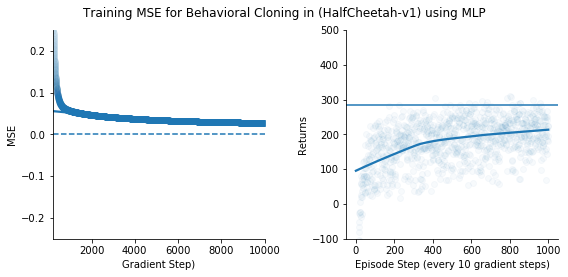

In [19]:
plot_returns_and_losses2(training_env1,ylim1=[-.25,.25],ylim2=[-100,500])
plt.savefig('cheetah_97_bc_10000iter.png')

### 3.1 Ant



In [20]:
# expert_policy_file = 'experts/Ant-v1.pkl'
# envname = 'Ant-v1'

# max_timesteps = 100
# num_rollouts = 97
# render = False
# rollout(expert_policy_file,envname,max_timesteps,num_rollouts,render)

In [21]:
expert_data_file = 'Ant_97'
env = 'Ant-v1'

training_env2 = train_and_evaluate_network_w_dagger(expert_data_file,
                                          env,
                                          normalize_obs=True,
                                          n_steps=10000,
                                          max_steps=100,
                                         hlayers=2,
                                         n_hidden_1=64,
                                         n_hidden_2=64,
                                         learning_rate=0.2,
                                        expert_step=False,
                                        dagger=False,
                                        whichrender=[],steps_to_run_before_gym=20)

one of inputs is all 0s
Training Data:
observations (9700, 111)
actions (9700, 8)
returns expert 412.8744518161535
obs (1, 111) (1, 111)


[2017-09-11 22:57:20,784] Making new env: Ant-v1


gradient step: 0
average returns (prev 100 steps): nan
observations shape: (9700, 111)
actions shape: (9700, 8)
gradient step: 100
average returns (prev 100 steps): -1483.587259864207
observations shape: (9700, 111)
actions shape: (9700, 8)
gradient step: 200
average returns (prev 100 steps): -1039.6218680028219
observations shape: (9700, 111)
actions shape: (9700, 8)
gradient step: 300
average returns (prev 100 steps): -683.6327365901269
observations shape: (9700, 111)
actions shape: (9700, 8)
gradient step: 400
average returns (prev 100 steps): -490.5653879092967
observations shape: (9700, 111)
actions shape: (9700, 8)
gradient step: 500
average returns (prev 100 steps): -362.7015927005765
observations shape: (9700, 111)
actions shape: (9700, 8)
gradient step: 600
average returns (prev 100 steps): -266.16777975667276
observations shape: (9700, 111)
actions shape: (9700, 8)
gradient step: 700
average returns (prev 100 steps): -202.09192130581195
observations shape: (9700, 111)
actions

gradient step: 6400
average returns (prev 100 steps): 209.407518500886
observations shape: (9700, 111)
actions shape: (9700, 8)
gradient step: 6500
average returns (prev 100 steps): 210.94315712417747
observations shape: (9700, 111)
actions shape: (9700, 8)
gradient step: 6600
average returns (prev 100 steps): 212.28237019340006
observations shape: (9700, 111)
actions shape: (9700, 8)
gradient step: 6700
average returns (prev 100 steps): 211.99136591419588
observations shape: (9700, 111)
actions shape: (9700, 8)
gradient step: 6800
average returns (prev 100 steps): 214.52799154189495
observations shape: (9700, 111)
actions shape: (9700, 8)
gradient step: 6900
average returns (prev 100 steps): 220.33772094917302
observations shape: (9700, 111)
actions shape: (9700, 8)
gradient step: 7000
average returns (prev 100 steps): 219.05246034535085
observations shape: (9700, 111)
actions shape: (9700, 8)
gradient step: 7100
average returns (prev 100 steps): 221.61106763900116
observations shape:

In [26]:
print('returns mean={0} (std={1}) for last 100 episodes'.format(np.round(np.mean(training_env2['returns'][-100:-1]),2),
                                                  np.round(np.std(training_env2['returns'][-100:-1]),2)))

returns mean=222.79 (std=70.51) for last 100 episodes


In [25]:
print('returns mean={0} (std={1}) for last 100 episodes'.format(np.round(np.mean(training_env2['returns_expert'][-100:-1]),2),
                                                  np.round(np.std(training_env2['returns_expert'][-100:-1]),2)))

returns mean=412.85 (std=29.93) for last 100 episodes


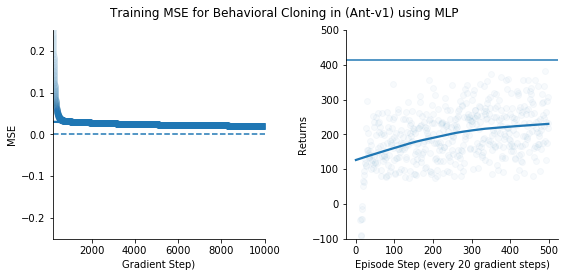

In [22]:
plot_returns_and_losses2(training_env2,ylim1=[-.25,.25],ylim2=[-100,500])
plt.savefig('ant_97_bc_10000iter.png')

## 3.2 Behavioral Cloning (Experimenting with Number of Rollouts) Ant







In [34]:
# expert_policy_file = 'experts/Ant-v1.pkl'
# envname = 'Ant-v1'

# max_timesteps = 100
# num_rollouts = 97
# render = False
# rollout(expert_policy_file,envname,max_timesteps,num_rollouts,render)

In [35]:
# expert_policy_file = 'experts/Ant-v1.pkl'
# envname = 'Ant-v1'

# max_timesteps = 100
# num_rollouts = 197
# render = False
# rollout(expert_policy_file,envname,max_timesteps,num_rollouts,render)

In [36]:
# expert_policy_file = 'experts/Ant-v1.pkl'
# envname = 'Ant-v1'

# max_timesteps = 100
# num_rollouts = 297
# render = False
# rollout(expert_policy_file,envname,max_timesteps,num_rollouts,render)

In [39]:
expert_data_file = 'Ant_97'
env = 'Ant-v1'

training_env_ant97 = train_and_evaluate_network_w_dagger(expert_data_file,
                                          env,
                                          normalize_obs=True,
                                          n_steps=2000,
                                          max_steps=100,
                                         hlayers=2,
                                         n_hidden_1=64,
                                         n_hidden_2=64,
                                         learning_rate=0.1,
                                        expert_step=False,
                                        dagger=False,
                                        whichrender=[2000],steps_to_run_before_gym=10)

one of inputs is all 0s
Training Data:
observations (9700, 111)
actions (9700, 8)
returns expert 412.8744518161535
obs (1, 111) (1, 111)


[2017-09-11 23:20:58,185] Making new env: Ant-v1


gradient step: 0
average returns (prev 100 steps): nan
observations shape: (9700, 111)
actions shape: (9700, 8)
gradient step: 100
average returns (prev 100 steps): -2659.433536520131
observations shape: (9700, 111)
actions shape: (9700, 8)
gradient step: 200
average returns (prev 100 steps): -1751.0582282223286
observations shape: (9700, 111)
actions shape: (9700, 8)
gradient step: 300
average returns (prev 100 steps): -1329.017338455203
observations shape: (9700, 111)
actions shape: (9700, 8)
gradient step: 400
average returns (prev 100 steps): -1075.6844059615973
observations shape: (9700, 111)
actions shape: (9700, 8)
gradient step: 500
average returns (prev 100 steps): -873.7107988434805
observations shape: (9700, 111)
actions shape: (9700, 8)
gradient step: 600
average returns (prev 100 steps): -743.1995789151049
observations shape: (9700, 111)
actions shape: (9700, 8)
gradient step: 700
average returns (prev 100 steps): -652.0115036470366
observations shape: (9700, 111)
actions 

In [38]:
expert_data_file = 'Ant_197'
env = 'Ant-v1'

training_env_ant197 = train_and_evaluate_network_w_dagger(expert_data_file,
                                          env,
                                          normalize_obs=True,
                                          n_steps=2000,
                                          max_steps=100,
                                         hlayers=2,
                                         n_hidden_1=64,
                                         n_hidden_2=64,
                                         learning_rate=0.1,
                                        expert_step=False,
                                        dagger=False,
                                        whichrender=[2000],steps_to_run_before_gym=10)

one of inputs is all 0s
Training Data:
observations (19700, 111)
actions (19700, 8)
returns expert 415.01727377795544
obs (1, 111) (1, 111)


[2017-09-11 23:18:32,258] Making new env: Ant-v1


gradient step: 0
average returns (prev 100 steps): nan
observations shape: (19700, 111)
actions shape: (19700, 8)
gradient step: 100
average returns (prev 100 steps): -1667.3852836493297
observations shape: (19700, 111)
actions shape: (19700, 8)
gradient step: 200
average returns (prev 100 steps): -1135.9258990665485
observations shape: (19700, 111)
actions shape: (19700, 8)
gradient step: 300
average returns (prev 100 steps): -903.6310736947294
observations shape: (19700, 111)
actions shape: (19700, 8)
gradient step: 400
average returns (prev 100 steps): -725.7360442437634
observations shape: (19700, 111)
actions shape: (19700, 8)
gradient step: 500
average returns (prev 100 steps): -586.1400826233071
observations shape: (19700, 111)
actions shape: (19700, 8)
gradient step: 600
average returns (prev 100 steps): -503.51379695148256
observations shape: (19700, 111)
actions shape: (19700, 8)
gradient step: 700
average returns (prev 100 steps): -416.9915186273188
observations shape: (1970

In [37]:
expert_data_file = 'Ant_297'
env = 'Ant-v1'

training_env_ant297 = train_and_evaluate_network_w_dagger(expert_data_file,
                                          env,
                                          normalize_obs=True,
                                          n_steps=2000,
                                          max_steps=100,
                                         hlayers=2,
                                         n_hidden_1=64,
                                         n_hidden_2=64,
                                         learning_rate=0.1,
                                        expert_step=False,
                                        dagger=False,
                                        whichrender=[2000],steps_to_run_before_gym=10)

one of inputs is all 0s
Training Data:
observations (29700, 111)
actions (29700, 8)
returns expert 414.7336215104013
obs (1, 111) (1, 111)


[2017-09-11 23:14:21,103] Making new env: Ant-v1


gradient step: 0
average returns (prev 100 steps): nan
observations shape: (29700, 111)
actions shape: (29700, 8)
gradient step: 100
average returns (prev 100 steps): -2044.0131620401655
observations shape: (29700, 111)
actions shape: (29700, 8)
gradient step: 200
average returns (prev 100 steps): -1446.6269450796842
observations shape: (29700, 111)
actions shape: (29700, 8)
gradient step: 300
average returns (prev 100 steps): -1075.7336463453096
observations shape: (29700, 111)
actions shape: (29700, 8)
gradient step: 400
average returns (prev 100 steps): -851.2622053784071
observations shape: (29700, 111)
actions shape: (29700, 8)
gradient step: 500
average returns (prev 100 steps): -679.3324190713448
observations shape: (29700, 111)
actions shape: (29700, 8)
gradient step: 600
average returns (prev 100 steps): -565.1960432151508
observations shape: (29700, 111)
actions shape: (29700, 8)
gradient step: 700
average returns (prev 100 steps): -468.2573014037693
observations shape: (2970

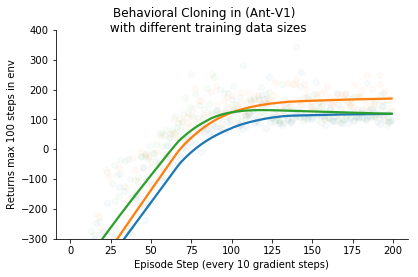

In [43]:
s = 10
ylim2 = [-300,400]
df_results2 = pd.DataFrame(data=np.vstack((np.arange(training_env_ant97['n_steps']/s),
                                           training_env_ant97['returns'],
                                          training_env_ant197['returns'],
                                          training_env_ant297['returns'])).T,columns=['Episode','Returns 97ro','Returns 197ro','Returns 297ro'])

fig,axes = plt.subplots(1,1,figsize=(6,4))

    # Training Returns 
plt.sca(axes)
sns.regplot(x='Episode',y='Returns 97ro',fit_reg=True,lowess=True,data=df_results2, scatter_kws={'alpha':0.03})#,x_bins=20)
sns.regplot(x='Episode',y='Returns 197ro',fit_reg=True,lowess=True,data=df_results2, scatter_kws={'alpha':0.03})#,x_bins=20)
sns.regplot(x='Episode',y='Returns 297ro',fit_reg=True,lowess=True,data=df_results2, scatter_kws={'alpha':0.03})#,x_bins=20)


plt.axhline(y=np.mean(training_env_ant97['returns_expert']))
plt.suptitle('Behavioral Cloning in (Ant-V1) \n with different training data sizes')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.xlabel('Episode Step (every '+str(s)+' gradient steps)')
plt.ylabel('Returns max 100 steps in env')
sns.despine()
plt.ylim(ylim2)
plt.savefig('ant_97_197_297.png')

## 4. Dagger



In [54]:
expert_policy_file = 'experts/Reacher-v1.pkl'
envname = 'Reacher-v1'

max_timesteps = None
num_rollouts = 500
render = False
rollout(expert_policy_file,envname,max_timesteps,num_rollouts,render)

obs (1, 11) (1, 11)
Instructions for updating:
Please use tf.global_variables instead.


[2017-09-11 23:41:40,823] From /Users/chris/Desktop/class_deepRL/hw1_gagne/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-09-11 23:41:40,842] From /Users/chris/anaconda/envs/env_class_deepRL/lib/python3.5/site-packages/tensorflow/python/util/tf_should_use.py:175: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-09-11 23:41:41,687] Making new env: Reacher-v1


mean return -3.82765361944
std of return 1.80732196614


In [55]:
expert_data_file = 'Reacher_97'
env = 'Reacher-v1'

expert_data_file = 'Reacher_500'
env = 'Reacher-v1'


training_env_reacher_bc = train_and_evaluate_network_w_dagger(expert_data_file,
                                          env,
                                          normalize_obs=True,
                                          n_steps=3000,
                                          max_steps=100,
                                         hlayers=2,
                                         n_hidden_1=64,
                                         n_hidden_2=64,
                                         learning_rate=0.1,
                                        expert_step=False,
                                        dagger=False,
                                        whichrender=[],steps_to_run_before_gym=10)

one of inputs is all 0s
Training Data:
observations (25000, 11)
actions (25000, 2)
returns expert -3.8276536194396504
obs (1, 11) (1, 11)


[2017-09-11 23:42:01,980] Making new env: Reacher-v1


gradient step: 0
average returns (prev 100 steps): nan
observations shape: (25000, 11)
actions shape: (25000, 2)
gradient step: 100
average returns (prev 100 steps): -879.7356464961252
observations shape: (25000, 11)
actions shape: (25000, 2)
gradient step: 200
average returns (prev 100 steps): -591.1681939807161
observations shape: (25000, 11)
actions shape: (25000, 2)
gradient step: 300
average returns (prev 100 steps): -480.0934359844293
observations shape: (25000, 11)
actions shape: (25000, 2)
gradient step: 400
average returns (prev 100 steps): -397.50189982033123
observations shape: (25000, 11)
actions shape: (25000, 2)
gradient step: 500
average returns (prev 100 steps): -339.40099751527043
observations shape: (25000, 11)
actions shape: (25000, 2)
gradient step: 600
average returns (prev 100 steps): -296.3403355506392
observations shape: (25000, 11)
actions shape: (25000, 2)
gradient step: 700
average returns (prev 100 steps): -260.11185741963675
observations shape: (25000, 11)


In [52]:
expert_data_file = 'Reacher_97'
env = 'Reacher-v1'

training_env_reacher_dagger = train_and_evaluate_network_w_dagger(expert_data_file,
                                          env,
                                          normalize_obs=True,
                                          n_steps=3000,
                                          max_steps=100,
                                         hlayers=2,
                                         n_hidden_1=64,
                                         n_hidden_2=64,
                                         learning_rate=0.1,
                                        expert_step=False,
                                        dagger=True,
                                        whichrender=[],steps_to_run_before_gym=10)

one of inputs is all 0s
Training Data:
observations (4850, 11)
actions (4850, 2)
returns expert -3.730134068431196
obs (1, 11) (1, 11)


[2017-09-11 23:38:24,525] Making new env: Reacher-v1


gradient step: 0
average returns (prev 100 steps): nan
observations shape: (4850, 11)
actions shape: (4850, 2)
gradient step: 100
average returns (prev 100 steps): -1205.3634140675797
observations shape: (5350, 11)
actions shape: (5350, 2)
gradient step: 200
average returns (prev 100 steps): -734.6509796461482
observations shape: (5850, 11)
actions shape: (5850, 2)
gradient step: 300
average returns (prev 100 steps): -535.4973669837209
observations shape: (6350, 11)
actions shape: (6350, 2)
gradient step: 400
average returns (prev 100 steps): -417.0834869952426
observations shape: (6850, 11)
actions shape: (6850, 2)
gradient step: 500
average returns (prev 100 steps): -341.37517416935873
observations shape: (7350, 11)
actions shape: (7350, 2)
gradient step: 600
average returns (prev 100 steps): -287.9552190750819
observations shape: (7850, 11)
actions shape: (7850, 2)
gradient step: 700
average returns (prev 100 steps): -248.5523941404755
observations shape: (8350, 11)
actions shape: (

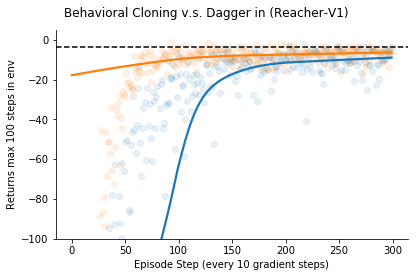

In [66]:
s = 10
ylim2 = [-100,5]
df_results2 = pd.DataFrame(data=np.vstack((np.arange(training_env_reacher_dagger['n_steps']/s),
                                           training_env_reacher_bc['returns'],
                                          training_env_reacher_dagger['returns'])).T,columns=['Episode','Returns bc','Returns dagger',])

fig,axes = plt.subplots(1,1,figsize=(6,4))

    # Training Returns 
plt.sca(axes)
sns.regplot(x='Episode',y='Returns bc',fit_reg=True,lowess=True,data=df_results2, scatter_kws={'alpha':0.1})#,x_bins=20)
sns.regplot(x='Episode',y='Returns dagger',fit_reg=True,lowess=True,data=df_results2, scatter_kws={'alpha':0.1})#,x_bins=20)


plt.axhline(y=np.mean(training_env_reacher_bc['returns_expert']),linestyle='--',color='k')
plt.suptitle('Behavioral Cloning v.s. Dagger in (Reacher-V1)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.xlabel('Episode Step (every '+str(s)+' gradient steps)')
plt.ylabel('Returns max 100 steps in env')
sns.despine()
plt.ylim(ylim2)
plt.savefig('reacher_dagger_bc.png')

In [63]:
print('returns mean={0} (std={1}) for last 100 episodes'.format(np.round(np.mean(training_env_reacher_bc['returns_expert'][-100:-1]),2),
                                                  np.round(np.std(training_env_reacher_bc['returns_expert'][-100:-1]),2)))

returns mean=-3.64 (std=1.78) for last 100 episodes


In [64]:
print('returns mean={0} (std={1}) for last 100 episodes'.format(np.round(np.mean(training_env_reacher_bc['returns'][-100:-1]),2),
                                                  np.round(np.std(training_env_reacher_bc['returns'][-100:-1]),2)))




returns mean=-10.27 (std=5.63) for last 100 episodes


In [67]:
print('returns mean={0} (std={1}) for last 100 episodes'.format(np.round(np.mean(training_env_reacher_dagger['returns'][-100:-1]),2),
                                                  np.round(np.std(training_env_reacher_dagger['returns'][-100:-1]),2)))




returns mean=-7.01 (std=3.05) for last 100 episodes
